## Top_5 vs. Top_1 Correctness
- MobileNetV2를 활용한 ImageNet 분류

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras

In [21]:
import numpy as np
import tensorflow_hub as hub
import os
import pathlib
from glob import glob
import pandas as pd
import random
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2

### 1. Tensorflow Hub
- 사전훈련된 MobileNet2

In [5]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

mbnet_v2 = keras.Sequential([hub.KerasLayer(handle = url,
                                            input_shape = (224, 224, 3),
                                            trainable = False)])

# 이전에는 include_top = False 였다. 지금은 지정하지 않음(1000개 분류할 것이므로)

- Model Summary

In [6]:
mbnet_v2.summary()
# 157개 레이어에 비해 파라미터가 굉장히 적다

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


## 2. ImageNetV2 TopImages

### 1) 이미지(ImageNetV2) 다운로드
- 1000가지 객체에 대한 이미지 10장씩 구성

In [8]:
%%time

image_url = 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-top-images.tar.gz'

data_dir = '/content/'

data_root_orig = keras.utils.get_file('imagenetV2',
                                      image_url,
                                      cache_dir = data_dir,
                                      extract = True)

1245929472/1245927936 [==============================] - 20s 0us/step
CPU times: user 6.68 s, sys: 4.76 s, total: 11.4 s
Wall time: 31 s


- 다운로드 경로 확인

In [10]:
data_root = pathlib.Path(glob('/content/datasets/*/')[0])
print(data_root)

/content/datasets/imagenetv2-top-images-format-val


- 이미지별 디렉토리 확인
  - 1000개

In [12]:
!ls /content/datasets/imagenetv2-top-images-format-val

0    155  211  269  325  382  439  496	552  609  666  722  78	 836  893  95
1    156  212  27   326  383  44   497	553  61   667  723  780  837  894  950
10   157  213  270  327  384  440  498	554  610  668  724  781  838  895  951
100  158  214  271  328  385  441  499	555  611  669  725  782  839  896  952
101  159  215  272  329  386  442  5	556  612  67   726  783  84   897  953
102  16   216  273  33	 387  443  50	557  613  670  727  784  840  898  954
103  160  217  274  330  388  444  500	558  614  671  728  785  841  899  955
104  161  218  275  331  389  445  501	559  615  672  729  786  842  9    956
105  162  219  276  332  39   446  502	56   616  673  73   787  843  90   957
106  163  22   277  333  390  447  503	560  617  674  730  788  844  900  958
107  164  220  278  334  391  448  504	561  618  675  731  789  845  901  959
108  165  221  279  335  392  449  505	562  619  676  732  79	 846  902  96
109  166  222  28   336  393  45   506	563  62   677  733  790  847  903

### 2) Image Label 다운로드
- 'ImageNetLabels.txt'

In [15]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'

DF = pd.read_table(url, header = None)

label_text = DF.values.reshape(-1)

# 이미지 파일 따로, label 따로 불러옴

- Label 확인
  - 1001개 주의!

In [16]:
print(len(label_text))
print(label_text[:5])
print(label_text[-5:])

# MobileNet을 테스트하기 위해 1000 개 중 10개씩 뽑음(총 10000장)
# 1000개의 디렉토리 (객체별로 각각 다른 디렉토리)
# 실제 1001개가 있다. 0번: background(어느것에도 포함되지 않으면 0번, 의미가 없음)
# 디렉토리는 0~999 인데, 실제 레이블은 1~1000 이다 (0번 background 제외)

1001
['background' 'tench' 'goldfish' 'great white shark' 'tiger shark']
['earthstar' 'hen-of-the-woods' 'bolete' 'ear' 'toilet tissue']


### 3) Image(X) vs. Label(y) 확인
- 이미지 랜덤 추출

In [18]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

random.choice(all_image_paths)

'/content/datasets/imagenetv2-top-images-format-val/808/d4104a380a614adad0cb837039b15550cc28fb02.jpeg'

- 9개의 Image vs. Label 출력

image_count:  10000


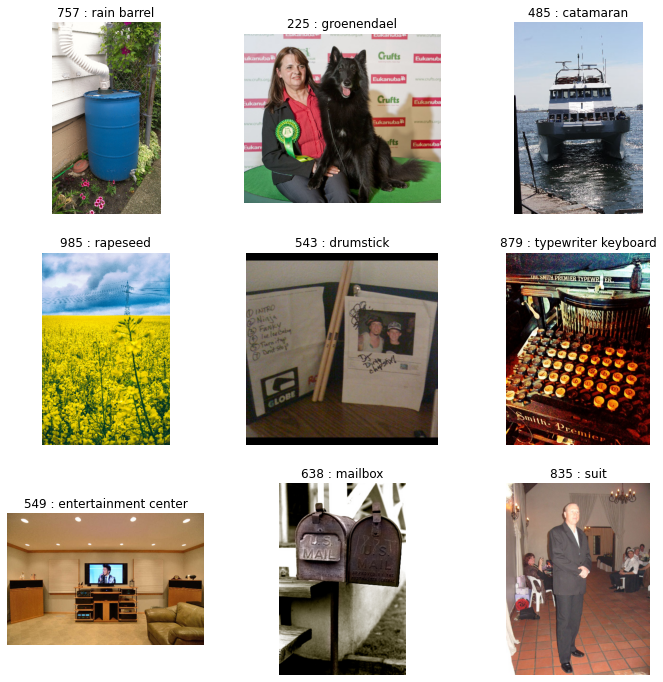

In [20]:
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count: ' , image_count)

plt.figure(figsize = (12, 12))

for n in range(9) :
  image_path = random.choice(all_image_paths)
  plt.subplot(3, 3, n + 1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2]) + 1
  plt.title(str(idx) + ' : ' + label_text[idx])
  plt.axis('off')

plt.show() 

## 3. MobileNet의 분류 라벨 확인

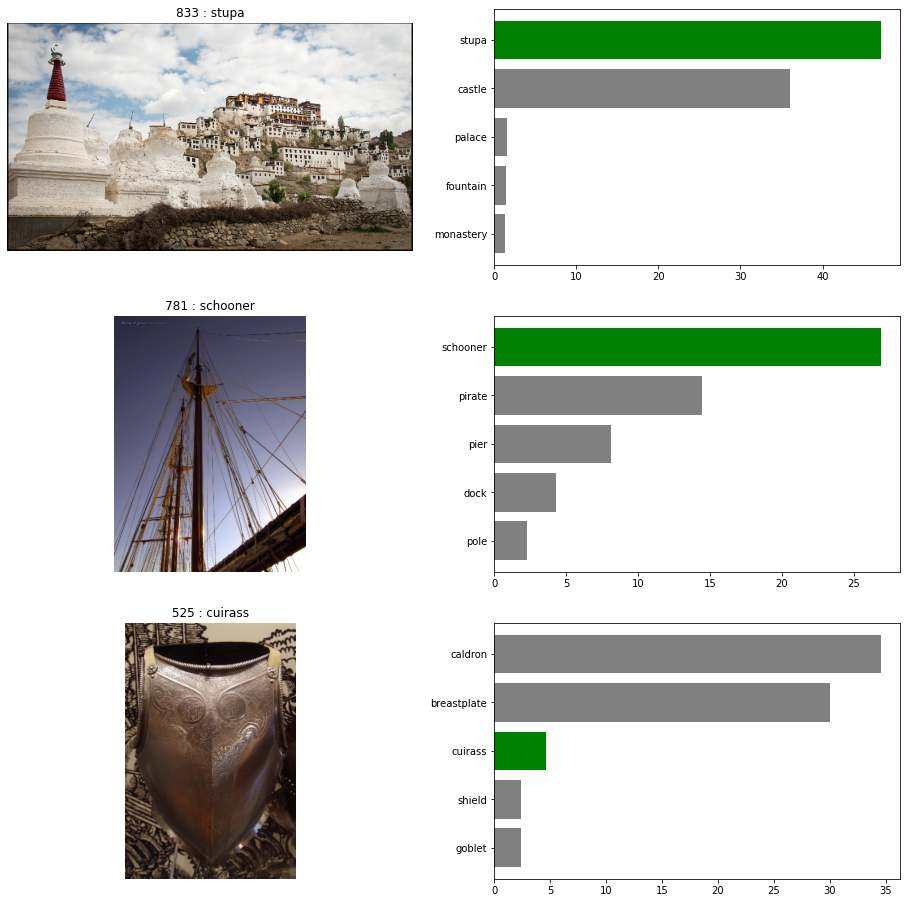

In [22]:
# cv2: openCV (Computer Vision)
# 이미지를 처리하기 위한 툴, ML과는 관련없음

# 다양한 기능들이 있다

plt.figure(figsize = (16, 16))

def softmax(x) :
  m = np.max(x)
  sm = np.exp(x - m) / np.sum(np.exp(x - m))
  return sm


for n in range(3) :

  # 랜덤 이미지 경로 추출
  image_path = random.choice(all_image_paths)

  # 이미지 출력
  plt.subplot(3, 2, n * 2 + 1)
  plt.imshow(plt.imread(image_path))
  idx = int(image_path.split('/')[-2]) + 1
  plt.title(str(idx) + ' : ' + label_text[idx])
  plt.axis('off')

  # Top5 예측값 출력 공간
  plt.subplot(3, 2, n * 2 + 2)

  # 이미지 크기 변경 및 정규화
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize = (224, 224))
  img = img / 255.0
  img = np.expand_dims(img, axis = 0)

  # MobileNetV2 이미지 분류
  logits = mbnet_v2.predict(img)[0]
  prediction = softmax(logits)

  # Top5 예측값
  top_5_predict = prediction.argsort()[::-1][:5]
  labels = [label_text[index] for index in top_5_predict]

  # Top5 막대그래프 색상 지정
  color = ['gray'] * 5
  if idx in top_5_predict :
    color[top_5_predict.tolist().index(idx)] = 'green'
  color = color[::-1]

  # Top5 막대그래프 출력
  plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color = color)
  plt.yticks(range(5), labels[::-1])

- np.argsort()
  - 오름차순 정렬 후 index 반환

In [23]:
# argsort 설명

AR = np.array([5555, 55, 5, 555])

print('오름차순 정렬: ' , np.sort(AR), '\n')

arg = np.argsort(AR)

print('오름차순 정렬 후 Index: ' , arg, '\n')

print('argsort 결과 적용: ' , AR[arg])

오름차순 정렬:  [   5   55  555 5555] 

오름차순 정렬 후 Index:  [2 1 3 0] 

argsort 결과 적용:  [   5   55  555 5555]


## 4. MobileNetV2의 분류성능 확인
- 약 9분

In [26]:
%%time

top_1 = 0
top_5 = 0

for image_path in all_image_paths :
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize = (224, 224))
  img = img / 255.0
  img = np.expand_dims(img, axis = 0)

  top_5_predict = mbnet_v2.predict(img)[0].argsort()[::-1][:5]
  idx = int(image_path.split('/')[-2]) + 1

  if idx in top_5_predict :
    top_5 += 1
    if top_5_predict[0] == idx :
      top_1 += 1

print('Top-5 Correctness: ' , top_5 , len(all_image_paths) * 100 , '%')
print('Top-1 Correctness: ' , top_1 / len(all_image_paths) * 100 , '%')

Top-5 Correctness:  8352 1000000 %
Top-1 Correctness:  59.06 %
CPU times: user 6min 25s, sys: 14.7 s, total: 6min 39s
Wall time: 6min 31s
